# Autoregressive Moving Average (ARMA): Sunspots data

In [28]:
from __future__ import print_function
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm

In [29]:
from statsmodels.graphics.api import qqplot

## Sunpots Data

In [30]:
print(sm.datasets.sunspots.NOTE)


Number of Observations - 309 (Annual 1700 - 2008)
Number of Variables - 1
Variable name definitions::

    SUNACTIVITY - Number of sunspots for each year

The data file contains a 'YEAR' variable that is not returned by load.



In [31]:
dta = sm.datasets.sunspots.load_pandas().data

In [ ]:
dta.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
del dta["YEAR"]

In [43]:

type(dta),dta.head()

(pandas.core.frame.DataFrame,             SUNACTIVITY
 1700-12-31            5
 1701-12-31           11
 1702-12-31           16
 1703-12-31           23
 1704-12-31           36)

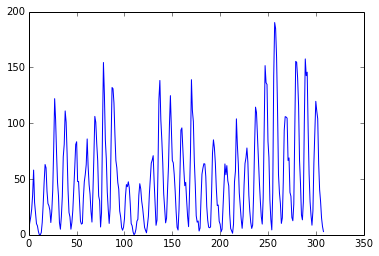

In [33]:
plt.plot(dta)

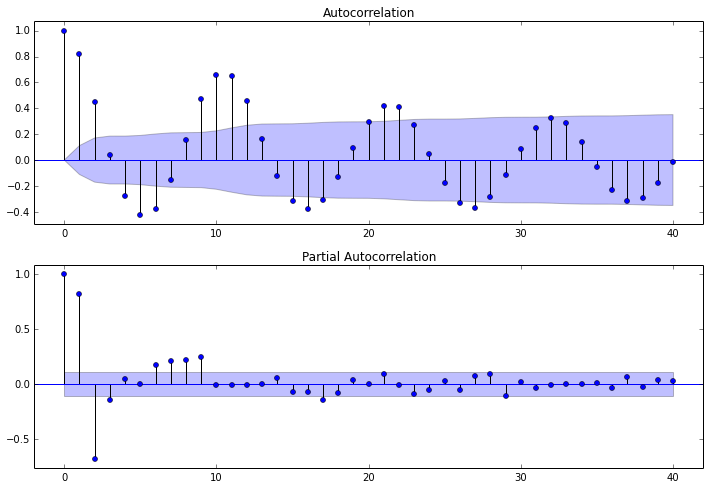

In [34]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta, lags=40, ax=ax2)

In [20]:
arma_mod20 = sm.tsa.ARMA(dta, (2,0)).fit()
print(arma_mod20.params)

const                49.659242
ar.L1.SUNACTIVITY     1.390656
ar.L2.SUNACTIVITY    -0.688571
dtype: float64


In [21]:
arma_mod30 = sm.tsa.ARMA(dta, (3,0)).fit()

In [22]:
print(arma_mod20.aic, arma_mod20.bic, arma_mod20.hqic)

2622.63633807 2637.56970317 2628.60672591


In [23]:
print(arma_mod30.params)

const                49.749948
ar.L1.SUNACTIVITY     1.300810
ar.L2.SUNACTIVITY    -0.508093
ar.L3.SUNACTIVITY    -0.129650
dtype: float64


In [24]:
print(arma_mod30.aic, arma_mod30.bic, arma_mod30.hqic)

2619.4036287 2638.07033508 2626.8666135


* Does our model obey the theory?

In [25]:
sm.stats.durbin_watson(arma_mod30.resid.values)

1.9564805580732743

AttributeError: 'FigureCanvasAgg' object has no attribute 'invalidate'

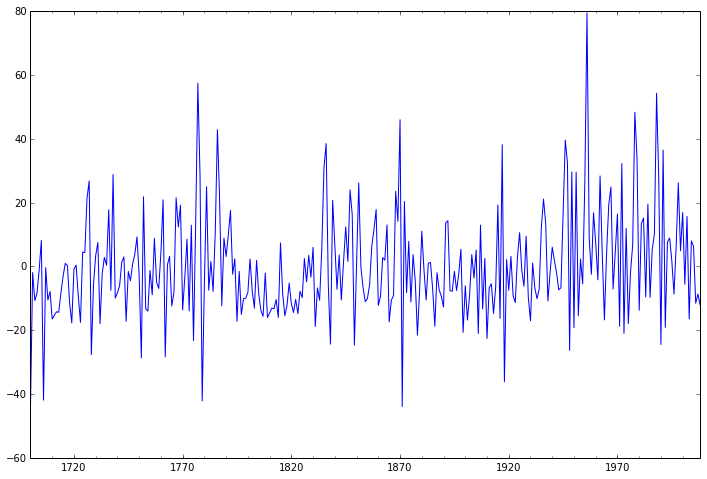

In [44]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = arma_mod30.resid.plot(ax=ax);

In [ ]:
resid = arma_mod30.resid

In [ ]:
stats.normaltest(resid)

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

In [ ]:
r,q,p = sm.tsa.acf(resid.values.squeeze(), qstat=True)
data = np.c_[range(1,41), r[1:], q, p]
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
print(table.set_index('lag'))

* This indicates a lack of fit.

* In-sample dynamic prediction. How good does our model do?

In [ ]:
predict_sunspots = arma_mod30.predict('1990', '2012', dynamic=True)
print(predict_sunspots)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = dta.ix['1950':].plot(ax=ax)
fig = arma_mod30.plot_predict('1990', '2012', dynamic=True, ax=ax, plot_insample=False)

In [ ]:
def mean_forecast_err(y, yhat):
    return y.sub(yhat).mean()

In [ ]:
mean_forecast_err(dta.SUNACTIVITY, predict_sunspots)

### Exercise: Can you obtain a better fit for the Sunspots model? (Hint: sm.tsa.AR has a method select_order)

### Simulated ARMA(4,1): Model Identification is Difficult

In [ ]:
from statsmodels.tsa.arima_process import arma_generate_sample, ArmaProcess

In [ ]:
np.random.seed(1234)
# include zero-th lag
arparams = np.array([1, .75, -.65, -.55, .9])
maparams = np.array([1, .65])

Let's make sure this model is estimable.

In [ ]:
arma_t = ArmaProcess(arparams, maparams)

In [ ]:
arma_t.isinvertible()

In [ ]:
arma_t.isstationary()

* What does this mean?

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(arma_t.generate_sample(size=50));

In [ ]:
arparams = np.array([1, .35, -.15, .55, .1])
maparams = np.array([1, .65])
arma_t = ArmaProcess(arparams, maparams)
arma_t.isstationary()

In [ ]:
arma_rvs = arma_t.generate_sample(size=500, burnin=250, scale=2.5)

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arma_rvs, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arma_rvs, lags=40, ax=ax2)

* For mixed ARMA processes the Autocorrelation function is a mixture of exponentials and damped sine waves after (q-p) lags. 
* The partial autocorrelation function is a mixture of exponentials and dampened sine waves after (p-q) lags.

In [ ]:
arma11 = sm.tsa.ARMA(arma_rvs, (1,1)).fit()
resid = arma11.resid
r,q,p = sm.tsa.acf(resid, qstat=True)
data = np.c_[range(1,41), r[1:], q, p]
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
print(table.set_index('lag'))

In [ ]:
arma41 = sm.tsa.ARMA(arma_rvs, (4,1)).fit()
resid = arma41.resid
r,q,p = sm.tsa.acf(resid, qstat=True)
data = np.c_[range(1,41), r[1:], q, p]
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
print(table.set_index('lag'))

### Exercise: How good of in-sample prediction can you do for another series, say, CPI

In [ ]:
macrodta = sm.datasets.macrodata.load_pandas().data
macrodta.index = pd.Index(sm.tsa.datetools.dates_from_range('1959Q1', '2009Q3'))
cpi = macrodta["cpi"]

#### Hint: 

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = cpi.plot(ax=ax);
ax.legend();

P-value of the unit-root test, resoundly rejects the null of no unit-root.

In [ ]:
print(sm.tsa.adfuller(cpi)[1])